In [88]:
import cv2 as cv
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import pandas as pd
import os

from collections import Counter

from keras import backend as K

from keras.applications import mobilenet, resnet50, inception_resnet_v2, inception_v3, vgg16
from keras.callbacks import CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import dot, Dense, Dropout, GlobalAveragePooling2D, Input, Lambda
from keras.models import Model
from keras.optimizers import RMSprop
from keras.regularizers import l2
from sklearn.model_selection import train_test_split


## Import CSV Data

In [89]:
# open bbox annotation csv file
csv_file = "/storage/data/humpback-whale-challenge/bb_labels1.csv"
df = pd.read_csv(filepath_or_buffer=csv_file)
df1 = df[['image','Id']]

# create dictionaries mapping image files to ids
class_distrib = df.groupby("Id").size()
n_classes = class_distrib.shape[0]

# print("Class Overview in Original Dataset: " + str(class_distrib))
print("\n# of unique classes: %d" %n_classes)

img_filenames = df["image"].tolist()
ids = df["Id"].tolist()
img_id_dict = dict(zip(ids,img_filenames))
# print(img_id_dict.keys())

# import images
root_dir = "/storage/data/humpback-whale-challenge"
img_dir = "train_crop1"
img_db = []
img_size = (224,224)

counter = 0
labels = []
for key, values in img_id_dict.items():

    # print("\nClass Name: %s" %key)
    # print("# Images: %s"  %values)

    img = cv.imread(filename=os.path.join(root_dir,img_dir,values), flags=0) # import as grayscale
    img = cv.resize(src=img,dsize=img_size,dst=img)
    # img = cv.cvtColor(src=img,code=cv.COLOR_BGR2GRAY,dst=img)

    img = np.array(img)
    # img.reshape((1, 300,300,1))
    # img_concat = np.concatenate(a_tuple=(img,img,img), axis=-1)
    img_concat = np.stack((img,img,img),axis=-1)

    img_db.append(img_concat)
    labels.append(counter)
    counter+=1

ids2 = list(img_id_dict.keys())



# of unique classes: 507


## Create train / val sets

### Data Augmentation

In [90]:
# visualize subset of augmented images
def plotImages( images_arr, n_images=5):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, figsize = (12,12))
    axes = axes.flatten()

    for img, ax in zip( images_arr, axes):

        if img.ndim != 2:
            img = img.reshape(img_size)

        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())

    plt.tight_layout()
    plt.show()


datagen = ImageDataGenerator(shear_range=0.05, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
img_aug = []
class_aug = []
class_counter = 0
aug_counter = 0
imgs_per_class = 20
input_shape = (224,224,3)

for img in img_db[0:500]:

    img = np.array(img)
    # print(img.shape)
    img = img.reshape((1,)+img.shape)
    print("Whale class: " + str(class_counter))
    
    # augment original image until counter > 10
    for batch in datagen.flow(x=img, batch_size=1):

        batch = batch.reshape(input_shape)
        img_aug.append(batch)

        class_aug.append(class_counter)

        aug_counter += 1
        if aug_counter >= imgs_per_class:
            break

    aug_counter = 0
    class_counter+=1

print("\nAugmented images: "+str(len(img_aug)))
print("Augmented labels: "+str(len(class_aug)))
# plotImages(img_aug[0:10])

Whale class: 0
Whale class: 1
Whale class: 2
Whale class: 3
Whale class: 4
Whale class: 5
Whale class: 6
Whale class: 7
Whale class: 8
Whale class: 9
Whale class: 10
Whale class: 11
Whale class: 12
Whale class: 13
Whale class: 14
Whale class: 15
Whale class: 16
Whale class: 17
Whale class: 18
Whale class: 19
Whale class: 20
Whale class: 21
Whale class: 22
Whale class: 23
Whale class: 24
Whale class: 25
Whale class: 26
Whale class: 27
Whale class: 28
Whale class: 29
Whale class: 30
Whale class: 31
Whale class: 32
Whale class: 33
Whale class: 34
Whale class: 35
Whale class: 36
Whale class: 37
Whale class: 38
Whale class: 39
Whale class: 40
Whale class: 41
Whale class: 42
Whale class: 43
Whale class: 44
Whale class: 45
Whale class: 46
Whale class: 47
Whale class: 48
Whale class: 49
Whale class: 50
Whale class: 51
Whale class: 52
Whale class: 53
Whale class: 54
Whale class: 55
Whale class: 56
Whale class: 57
Whale class: 58
Whale class: 59
Whale class: 60
Whale class: 61
Whale class: 62
Wh

Whale class: 489
Whale class: 490
Whale class: 491
Whale class: 492
Whale class: 493
Whale class: 494
Whale class: 495
Whale class: 496
Whale class: 497
Whale class: 498
Whale class: 499

Augmented images: 10000
Augmented labels: 10000


### Split original datset

In [91]:
# split into 70% train / 30% val
x_train, x_val = train_test_split(img_aug, shuffle=False, test_size=0.3, random_state=0)
y_train, y_val = train_test_split(class_aug, shuffle=False, test_size=0.3, random_state=0)

# convert to numpy arrays
x_train = np.array(x_train, dtype=np.float32)
x_val = np.array(x_val, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int)
y_train = np.reshape(y_train, newshape=(y_train.shape[0], 1))
y_val = np.array(y_val, dtype=np.int)
y_val = np.reshape(y_val, newshape=(y_val.shape[0], 1))

x_train /= 255
x_val /= 255

print("\nx_train: "+str(x_train.shape))
print("y_train: "+str(y_train.shape))
print("Memory Size: "+str(x_train.nbytes/1e9))
print("x_val: "+str(x_val.shape))
print("y_val: "+str(y_val.shape))

# print(str(y_val[0:20]))



x_train: (7000, 224, 224, 3)
y_train: (7000, 1)
Memory Size: 4.214784
x_val: (3000, 224, 224, 3)
y_val: (3000, 1)


## Create train / val pairs

### Base model definition that generates a (n,1) feature vector for an input image

In [92]:
def create_base_model(input_shape, base_id):

    # Inception-v3
    if base_id is 0:
        base = inception_v3.InceptionV3(input_shape = input_shape, weights='imagenet', include_top=False)
        base_name = 'Inception-V3'

    # MobileNet
    elif base_id is 1:
        base = mobilenet.MobileNet(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'MobileNet'

    #Inception-ResNet-v2
    elif base_id is 2:
        base = inception_resnet_v2.InceptionResNetV2(input_shape = input_shape, weights='imagenet', include_top=False)
        base_name = 'InceptionResNet-v2'

    #ResNet50
    elif base_id is 3:
        base = resnet50.ResNet50(input_shape = input_shape, weights='imagenet', include_top=False)
        base_name = 'ResNet50'
    
    #VGG16
    elif base_id is 4:
        base = vgg16.VGG16(input_shape = (224,224,3), weights='imagenet', include_top=False)
        base_name = 'VGG16'

    print("\nBase Network: %s" %base_name)

    top = GlobalAveragePooling2D()(base.output)

    # freeze all layers in the base network
    for layers in base.layers:
        layers.trainable = False

    model = Model(inputs=base.input,outputs=top,name='base_model')

    return model



### Use base model as feature extractor to generate encodings

In [93]:
base_id = 4 # 0 = Inception-v3, 1 = MobileNet, 2 = Inception-ResNet-v2, 3= ResNet50, 4=VGG16
base_model = create_base_model(input_shape=input_shape, base_id=base_id)

x_train_encoding = base_model.predict(x=x_train, batch_size=32, verbose=1)
x_val_encoding = base_model.predict(x=x_val, batch_size=32, verbose=1)
input_shape = x_train_encoding.shape[1:]

print("\nTrain Encoding: "+str(x_train_encoding.shape))


Base Network: VGG16
3000/3000 [==============================] - 27s 9ms/step

Train Encoding: (7000, 512)


### Generate positive / negative pairs for training / val encodings

In [94]:

# create positive / negative training example pairs
def create_pairs(x, idcs, n_classes, class_idx_start, class_idx_end):

    pairs = []
    labels = [] # 1 = positive pair, 0 = negative pair

    # find the minimum number of examples per class
    # n_min = max(min([len(idcs[d]) for d in range(class_idx_start,class_idx_end,1)])-1,1)
    n_min = min([len(idcs[d]) for d in range(n_classes)])-1
    print("n_min %d" %n_min)

    # for n in range(class_idx_start, class_idx_end, 1):
    for n in range(n_classes):

        # print("\nClass %i" %n)

        counter_pos = 0
        counter_neg = 0

        # create n_min positive pairs and n_min negative pairs per class
        for i in range(n_min):

            # positive example
            z1, z2 = idcs[n][i], idcs[n][i+1]
            pairs += [[x[z1], x[z2]]]
            counter_pos += 1

            # negative example
            inc = random.randrange(1,n_classes)
            n_rand = (n+inc) % n_classes
            z1, z2 = idcs[n][i], idcs[n_rand][i]
            pairs += [[x[z1], x[z2]]]
            counter_neg += 1

            labels += [1,0]

        # print("\t# of positive pairs: %i" % counter_pos)
        # print("\t# of negative pairs: %i" % counter_neg)

    return np.array(pairs,dtype=np.float32), np.array(labels)


# find indices in loaded images in x_train & y_train corresponding to each class
train_class_start = int(y_train[0])
train_class_end = int(y_train[len(y_train)-1])
n_train_classes = train_class_end-train_class_start + 1
val_class_start = int(y_val[0])
val_class_end = int(y_val[len(y_val)-1])
n_val_classes = val_class_end-val_class_start + 1
print("Train class range: %d-%d" %(train_class_start, train_class_end))
print("Val class range: %d-%d" %(val_class_start, val_class_end))
print("# of train classes: %d" %n_train_classes)
print("# of val classes: %d" %n_val_classes)





Train class range: 0-349
Val class range: 350-499
# of train classes: 350
# of val classes: 150


In [95]:
# idcs_train = [np.where(y_train == i)[0] for i in range(train_class_start,train_class_start+2,1)]
idcs_train = [np.where(y_train == i)[0] for i in range(train_class_start,train_class_end+1,1)]
idcs_val = [np.where(y_val == i)[0] for i in range(val_class_start,val_class_end+1,1)]

# print("\n"+str(idcs_train))
# print("\n"+str(idcs_val))

# create train & test pairs from original sets
x_train_pair, y_train_pair = create_pairs(x_train_encoding, idcs_train, n_train_classes, train_class_start, train_class_end)
x_val_pair, y_val_pair = create_pairs(x_val_encoding, idcs_val, n_val_classes, val_class_start, val_class_end)

print("\nX-train pair size: " + str(x_train_pair.shape))
print("Y-train pair Size: " + str(y_train_pair.shape))

print("X-val pair size: " + str(x_val_pair.shape))
print("Y-val pair size: " + str(y_val_pair.shape))

n_min 19
n_min 19

X-train pair size: (13300, 2, 512)
Y-train pair Size: (13300,)
X-val pair size: (5700, 2, 512)
Y-val pair size: (5700,)


## Define Siamese Model 

In [96]:
# calculate cosine distance b/t feature vector outputs from base network
def cos_distance(feat_vects):

    K.set_epsilon(1e-07)
    epsilon = K.epsilon()

    x1, x2 = feat_vects

    result = K.maximum(x=dot(inputs=[x1, x2], axes=1, normalize=True), y=epsilon)

    return result


# create a siamese model that calculates similarity b/t two feature vectors
def create_siamese_model(encoding_shape):

    encoding_a = Input(shape=encoding_shape)
    encoding_b = Input(shape=encoding_shape)

    fc1_a = Dense(units=2048, activation='relu', kernel_regularizer=l2(l=0.0001), name='fc1_a')(encoding_a)
    fc1_b = Dense(units=2048, activation='relu', kernel_regularizer=l2(l=0.0001), name='fc1_b')(encoding_b)

    # fc1_a = Dropout(rate=0.5)(fc1_a)
    # fc1_b = Dropout(rate=0.5)(fc1_b)
    # distance = Lambda(function=l1_distance, name='l1_distance', )([fc1_a, fc1_b])
    # distance = Lambda(function=l2_distance, name='l2_distance', )([fc1_a, fc1_b])
    # distance = Lambda(function=cos_distance, name='cos_distance', )([encoding_a, encoding_b])
    distance = Lambda(function=cos_distance, name='cos_distance', )([fc1_a, fc1_b])

    prediction = Dense(units=1, activation='sigmoid', kernel_regularizer=l2(l=0.0000), name='sigmoid')(distance)

    model = Model(inputs=[encoding_a, encoding_b], outputs=prediction, name='siamese_model')

    return model

# create siamese model
siamese_model = create_siamese_model(input_shape)
print(siamese_model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 512)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 512)          0                                            
__________________________________________________________________________________________________
fc1_a (Dense)                   (None, 2048)         1050624     input_11[0][0]                   
__________________________________________________________________________________________________
fc1_b (Dense)                   (None, 2048)         1050624     input_12[0][0]                   
__________________________________________________________________________________________________
cos_distan

## Training

In [97]:
def step_decay_schedule(lr_initial=0.001, decay=0.75, step_size=10):
  
  def schedule(epoch):
      return lr_initial*math.pow(decay, math.floor((1+epoch)/step_size))
      
  return LearningRateScheduler(schedule=schedule, verbose=1)


def get_lr_metric(optimizer):

    def lr(y_true, y_pred):
        return optimizer.lr
    return lr


# define callbacks
early_stopper = EarlyStopping(monitor='val_loss', patience=10)
lr_schedule = step_decay_schedule()
reduce_lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=10, min_lr = 1e-5, verbose=1)

callback_type = 0 # 0=step decay, 1=val_loss decay
cbks = []

if callback_type is 0:
  cbks = [lr_schedule]
elif callback_type is 1:
  cbks = [reduce_lr_schedule]

# training setup
batch_size = 32
n_epochs = 100
optim = RMSprop()
lr_metric = get_lr_metric(optim)
siamese_model.compile(loss="binary_crossentropy", optimizer=optim, metrics=['accuracy', lr_metric])

In [98]:
history = siamese_model.fit(x=[x_train_pair[:, 0], x_train_pair[:, 1]],
                  y=y_train_pair,
                  batch_size=batch_size,
                  epochs=n_epochs,
                  validation_data=([x_val_pair[:, 0], x_val_pair[:, 1]], y_val_pair),
                  shuffle=True,
                  verbose=True,
                  callbacks=cbks) 

Train on 13300 samples, validate on 5700 samples
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
13300/13300 [==============================] - 4s 284us/step - loss: 0.6981 - acc: 0.4953 - lr: 0.0010 - val_loss: 0.6934 - val_acc: 0.5000 - val_lr: 0.0010
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
13300/13300 [==============================] - 3s 218us/step - loss: 0.6936 - acc: 0.4987 - lr: 0.0010 - val_loss: 0.6933 - val_acc: 0.5000 - val_lr: 0.0010
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
13300/13300 [==============================] - 3s 217us/step - loss: 0.6776 - acc: 0.6610 - lr: 0.0010 - val_loss: 0.6682 - val_acc: 0.6630 - val_lr: 0.0010
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
13300/13300 [==============================] - 3s 217us/step - loss: 0.6413 - acc: 0.7587 - lr: 0.0010 - val_loss: 0.6243 - val_acc: 0.7616 - val_lr: 0.0010

13300/13300 [==============================] - 3s 215us/step - loss: 0.2891 - acc: 0.9127 - lr: 4.2188e-04 - val_loss: 0.3626 - val_acc: 0.8561 - val_lr: 4.2188e-04
Epoch 34/100

Epoch 00034: LearningRateScheduler reducing learning rate to 0.000421875.
13300/13300 [==============================] - 3s 215us/step - loss: 0.2876 - acc: 0.9123 - lr: 4.2188e-04 - val_loss: 0.3949 - val_acc: 0.8518 - val_lr: 4.2188e-04
Epoch 35/100

Epoch 00035: LearningRateScheduler reducing learning rate to 0.000421875.
13300/13300 [==============================] - 3s 217us/step - loss: 0.2833 - acc: 0.9147 - lr: 4.2188e-04 - val_loss: 0.3773 - val_acc: 0.8516 - val_lr: 4.2188e-04
Epoch 36/100

Epoch 00036: LearningRateScheduler reducing learning rate to 0.000421875.
13300/13300 [==============================] - 3s 217us/step - loss: 0.2811 - acc: 0.9139 - lr: 4.2188e-04 - val_loss: 0.3701 - val_acc: 0.8575 - val_lr: 4.2188e-04
Epoch 37/100

Epoch 00037: LearningRateScheduler reducing learning rate to 0

13300/13300 [==============================] - 3s 215us/step - loss: 0.2313 - acc: 0.9314 - lr: 1.7798e-04 - val_loss: 0.3745 - val_acc: 0.8456 - val_lr: 1.7798e-04
Epoch 66/100

Epoch 00066: LearningRateScheduler reducing learning rate to 0.000177978515625.
13300/13300 [==============================] - 3s 218us/step - loss: 0.2307 - acc: 0.9327 - lr: 1.7798e-04 - val_loss: 0.3798 - val_acc: 0.8400 - val_lr: 1.7798e-04
Epoch 67/100

Epoch 00067: LearningRateScheduler reducing learning rate to 0.000177978515625.
13300/13300 [==============================] - 3s 215us/step - loss: 0.2298 - acc: 0.9329 - lr: 1.7798e-04 - val_loss: 0.3864 - val_acc: 0.8437 - val_lr: 1.7798e-04
Epoch 68/100

Epoch 00068: LearningRateScheduler reducing learning rate to 0.000177978515625.
13300/13300 [==============================] - 3s 215us/step - loss: 0.2293 - acc: 0.9340 - lr: 1.7798e-04 - val_loss: 0.3948 - val_acc: 0.8404 - val_lr: 1.7798e-04
Epoch 69/100

Epoch 00069: LearningRateScheduler reducing 

13300/13300 [==============================] - 3s 215us/step - loss: 0.2135 - acc: 0.9405 - lr: 7.5085e-05 - val_loss: 0.4042 - val_acc: 0.8318 - val_lr: 7.5085e-05
Epoch 97/100

Epoch 00097: LearningRateScheduler reducing learning rate to 7.508468627929687e-05.
13300/13300 [==============================] - 3s 218us/step - loss: 0.2131 - acc: 0.9397 - lr: 7.5085e-05 - val_loss: 0.3972 - val_acc: 0.8349 - val_lr: 7.5085e-05
Epoch 98/100

Epoch 00098: LearningRateScheduler reducing learning rate to 7.508468627929687e-05.
13300/13300 [==============================] - 3s 218us/step - loss: 0.2129 - acc: 0.9383 - lr: 7.5085e-05 - val_loss: 0.3974 - val_acc: 0.8361 - val_lr: 7.5085e-05
Epoch 99/100

Epoch 00099: LearningRateScheduler reducing learning rate to 7.508468627929687e-05.
13300/13300 [==============================] - 3s 212us/step - loss: 0.2131 - acc: 0.9392 - lr: 7.5085e-05 - val_loss: 0.4068 - val_acc: 0.8307 - val_lr: 7.5085e-05
Epoch 100/100

Epoch 00100: LearningRateSchedu

### Training Loss Graph

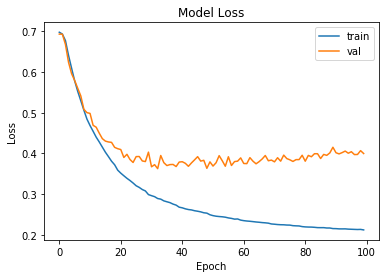

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Learning Rate Graph

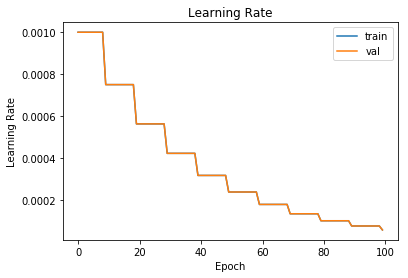

In [100]:
# print(str(history.history.keys()))

plt.plot(history.history['lr'])
plt.plot(history.history['val_lr'])
plt.title('Learning Rate')
plt.ylabel('Learning Rate')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Loss vs Learning Rate

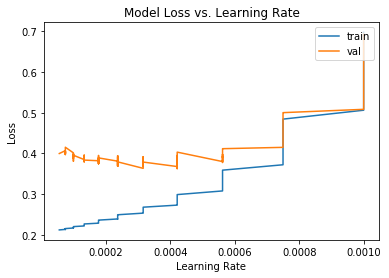

In [101]:
plt.plot(history.history['lr'],history.history['loss'])
plt.plot(history.history['lr'],history.history['val_loss'])
plt.title('Model Loss vs. Learning Rate')
plt.ylabel('Loss')
plt.xlabel('Learning Rate')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


## Accuracy Evaluation

In [102]:
# calculates accuracy between predicted and ground-truth similarities
def compute_accuracy(y_true, y_pred):

    prediction = y_pred.ravel() > 0.5

    return np.mean(prediction == y_true)


# compute accuracy on train &  validation sets
print("\nPredictions with Trained Model:")
y_pred_train = siamese_model.predict(x=[x_train_pair[:,0],x_train_pair[:,1]], verbose=True)
y_pred_val = siamese_model.predict(x=[x_val_pair[:, 0], x_val_pair[:, 1]], verbose=True)

acc_train = compute_accuracy(y_train_pair,y_pred_train)
acc_val = compute_accuracy(y_val_pair,y_pred_val)
print("Training set accuracy: %0.2f%%" % (100*acc_train))
print("Validation set accuracy: %0.2f%%" % (100*acc_val))


Predictions with Trained Model:
5700/5700 [==============================] - 0s 36us/step
Training set accuracy: 93.80%
Validation set accuracy: 83.75%


In [103]:
print(str(100*y_pred_train[0:20]))

[[8.9450455e+01]
 [1.9566892e-01]
 [7.4529228e+01]
 [2.9829925e-02]
 [8.6678711e+01]
 [1.1821645e+00]
 [7.9474487e+01]
 [2.0582882e+01]
 [8.0612320e+01]
 [6.5654859e-02]
 [7.7237633e+01]
 [5.3378158e+00]
 [8.2537910e+01]
 [7.2560066e+01]
 [8.8699951e+01]
 [3.7374783e+00]
 [7.3928543e+01]
 [4.6333489e+00]
 [8.0542854e+01]
 [6.7399612e+01]]
